PROJECT 4 - GROUP 2

# Machine Learning Fairness Algorithms Evaluation: A Comparative Analysis of Learning Fair Representations and Fairness Constraints: Mechanisms for Fair Classification

## 1. Introduction

Bias in algorithmic decision-making systems, particularly within the criminal justice system, is a pressing concern. Risk assessment tools like COMPAS are increasingly used to predict recidivism, potentially influencing sentencing decisions. However, these algorithms can perpetuate societal biases, leading to discriminatory outcomes for certain groups.

This paper explores two promising approaches to achieving fairness in classification tasks:

- Learning Fair Representations: This approach focuses on data representation. It aims to learn informative features from the data while simultaneously obfuscating sensitive attributes, like race, that could lead to bias.
- Fairness Constraints (FNC), a mechanism starting with logistic regression and support vector machines, leveraging a novel intuitive measure of decision boundary (un)fairness

**Motivation:**

Across the United States, criminal justice systems are turning to algorithms to assess recidivism risk. Tools like COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) have been criticized for racial bias. Studies have shown that COMPAS scores are more likely to incorrectly classify Black defendants as high risk for recidivism and white defendants as low risk.

**Our Approach:**

This work investigates and compares the effectiveness of these two contrasting approaches in achieving fairness within risk assessment algorithms. We analyze a dataset of COMPAS scores spanning two years to understand:

- How well each approach balances accuracy and fairness?
- Do these methods mitigate the observed discrimination in COMPAS scores?
- Through this analysis, we aim to contribute to the development of fairer and more equitable risk assessment tools in the criminal justice system.

## 2. Preparation
### 2.1 Import Libraries and Packages

In [ ]:
import numpy as np
import pandas as pd
import itertools
import copy
import math
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import scipy
from scipy import optimize
import scipy.optimize as optim
from scipy.optimize import minimize
from numpy import linalg as LA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###2.2 Process & Clean Data

In [ ]:
# Load the data
df_raw = pd.read_csv('/content/drive/My Drive/compas-scores-two-years.csv')


In [ ]:
print(df_raw.columns)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [ ]:
# Calculate the length of stay in hours
length_of_stay = pd.to_datetime(df_raw["c_jail_out"]) - pd.to_datetime(df_raw["c_jail_in"])
df = df_raw.copy()


In [ ]:
# Convert seconds to days
df["length_of_stay"] = length_of_stay.dt.total_seconds() / 3600 / 24

# Select features of interest for Approach 2
df = df[["two_year_recid", "race", "sex", "age", "c_charge_degree", "priors_count", "length_of_stay"]]

# Apply filters and drop NA
df = df.dropna()
df = df.loc[(df["length_of_stay"] > 0) & ((df["race"]== "African-American") | (df["race"]== "Caucasian"))]


# Encoding categorical features
# Encode 'race' as 0 for 'African-American' and 1 for others
df['race'] = df['race'].apply(lambda x: 0 if x == 'African-American' else 1)

# Encode 'sex' as 0 for 'Female' and 1 for 'Male'
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'Female' else 1)

# Encode 'age' into three categories: 0 if age < 25, 1 if age is between 25 and 45, and 2 if age > 45
df['age'] = df['age'].apply(lambda x: 0 if x < 25 else (2 if x > 45 else 1))

# Encode 'c_charge_degree' as 0 for misdemeanors ('M') and 1 for felonies
df['c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 0 if x == 'M' else 1)

# Encode 'priors_count' into three categories: 0 if no priors, 1 if 1 to 3 priors, and 2 if more than 3 priors
df['priors_count'] = df['priors_count'].apply(lambda x: 0 if x == 0 else (2 if x > 3 else 1))

# Normalizing 'length_of_stay' using z-score normalization (standardization)
# This adjusts the length of stay feature to have mean of 0 and standard deviation of 1
df['length_of_stay'] = (df['length_of_stay'] - df['length_of_stay'].mean()) / df['length_of_stay'].std()

# Display the first few rows of the modified DataFrame
print(df.head())


   two_year_recid  race  sex  age  c_charge_degree  priors_count  \
1               1     0    1    1                1             0   
2               1     0    1    0                1             2   
6               1     1    1    1                1             2   
8               0     1    0    1                0             0   
9               1     1    1    0                1             1   

   length_of_stay  
1       -0.185101  
2       -0.355556  
6       -0.256734  
8       -0.320147  
9       -0.357403  


##2.2 Training & Test Sets

In [ ]:
# Shuffle the dataset to randomize the order of rows
df_shuffled = df.sample(frac=1, random_state=1)

# Calculate the index to split the dataset into training and test sets
i = int(len(df_shuffled) * 0.7)  # 70% of the data is used for the training set

# Split the dataset into training and test sets based on the calculated index
train = df_shuffled[:i]  # The first 70% of rows go into the training set
test = df_shuffled[i:]   # The remaining 30% go into the test set

# Define the target variable, sensitive attribute, and the list of features for analysis
label = "two_year_recid"
sensitive = "race"
features = ["sex", "age", "c_charge_degree", "priors_count", "length_of_stay"]


In [ ]:
df1 = df[features]
y = df[label]

In [ ]:
x_train, y_train, race_train = train[features], train[label].to_numpy(), train[sensitive]
x_test, y_test, race_test = test[features], test[label].to_numpy(), test[sensitive]

# 3. Baseline
## 3.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Define the function for calculating calibration as the percentage accuracy difference
def MyCalibration(sensitive_attr, y_pred, y_true):
    # Identify indices for each racial group
    cau_index = np.where(sensitive_attr == 1)[0]  # Caucasians
    african_index = np.where(sensitive_attr == 0)[0]  # African-Americans

    # Calculate accuracy for Caucasians
    y_pred_cau = y_pred[cau_index]
    y_true_cau = y_true[cau_index]
    Acc_cau = np.mean(y_pred_cau == y_true_cau) * 100  # Convert fraction to percentage

    # Calculate accuracy for African-Americans
    y_pred_african = y_pred[african_index]
    y_true_african = y_true[african_index]
    Acc_african = np.mean(y_pred_african == y_true_african) * 100  # Convert fraction to percentage

    # Calculate calibration as the difference in accuracies
    calibration = Acc_cau - Acc_african
    return calibration

# Logistic regression model fitting
logReg1 = LogisticRegression(random_state=0).fit(x_train, y_train)

# Use the model to predict on training and test sets
y_pred_train = logReg1.predict(x_train)
y_pred_test = logReg1.predict(x_test)

# Create a summary dictionary
summary_logReg = {
    "Methods": ["LR", "LR"],
    "Set": ["Train", "Test"],
    "Accuracy (%)": [
        np.mean(y_pred_train == y_train) * 100,  # Training accuracy
        np.mean(y_pred_test == y_test) * 100     # Test accuracy
    ],
    "Calibration(%)": [
        MyCalibration(race_train, y_pred_train, y_train),  # Calibration on training set
        MyCalibration(race_test, y_pred_test, y_test)      # Calibration on test set
    ]
}

# Convert the summary to a DataFrame for display
summary_df = pd.DataFrame(summary_logReg)
print(summary_df)


  Methods    Set  Accuracy (%)  Calibration(%)
0      LR  Train     66.135061       -1.317686
1      LR   Test     66.104651        3.605784


## 3.2 Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Train the SVM model using a linear kernel
svm_model1 = SVC(kernel='linear', probability=True, random_state=0)
svm_model1.fit(x_train, y_train)

# Predict on training and test sets
y_pred_train_svm = svm_model1.predict(x_train)
y_pred_test_svm = svm_model1.predict(x_test)

# Create a summary of the SVM model's performance
summary_svm = {
    "Methods": ["SVM", "SVM"],
    "Set": ["Train", "Test"],
    "Accuracy (%)": [
        svm_model1.score(x_train, y_train) * 100,  # Training accuracy
        svm_model1.score(x_test, y_test) * 100     # Test accuracy
    ],
    "Calibration(%)": [
        MyCalibration(race_train, y_pred_train_svm, y_train),  # Calibration on training set
        MyCalibration(race_test, y_pred_test_svm, y_test)      # Calibration on test set
    ]
}

# Display the summary in a DataFrame
summary_df_svm = pd.DataFrame(summary_svm)
print(summary_df_svm)

  Methods    Set  Accuracy (%)  Calibration(%)
0     SVM  Train     61.948667       -0.201786
1     SVM   Test     61.802326        2.186345


# 4. Implementation of Approach 1 (LFR)

Approach 1 is an algorithm designed for a clustering-based statistical modeling in the context of fairness-aware machine learning.

 It involves using data points labeled x’s and y, along with a sensitive variable (such as race in the Compas case), to compute Shapley values. These values are calculated by observing conditional probabilities and leveraging the structured dataset to gauge the trade-off between accuracy and discrimination when a variable is removed from the x matrix.

In [ ]:
from sklearn.metrics import accuracy_score
import math
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#LFR
def distances(X, V, alpha):
  N,D = X.shape
  K,D = V.shape
  dists = np.zeros((N, D))
  for i in range(N):
    for d in range(D):
      for k in range(K):
        dists[i, k] += (X[i, d] - V[k, d]) * (X[i, d] - V[k, d]) * alpha[d]
    return dists

def M_nks(dists,K):
  N,D = dists.shape
  upper = np.zeros((N,K))
  lower = np.zeros(N)
  M_nks = np.zeros((N,K))
  for i in range(N):
    for j in range(K):
      upper[i,j] = np.exp(-dists[i,j])
      lower[i] += upper[i,j]
    for j in range(K):
      if lower[i]:
        M_nks[i,j] = upper[i,j]/lower[i]
      else:
        M_nks[i, j] = upper[i, j] / 1e-6
  return M_nks

def M_ks (X,M_nks):
  N,K = M_nks.shape
  M_ks = np.zeros(K)
  for i in range(K):
    for j in range(N):
      M_ks[i] += M_nks[j,i]
    M_ks[i] = M_ks[i]/N
  return M_ks

def X_hat(X,V,M_nks):
  N,D = X.shape
  K,D = V.shape
  X_hat = np.zeros((N,D))
  for i in range(N):
    for d in range(D):
      for j in range(K):
        X_hat[i,d] += M_nks[i,j]*V[j,d]
  return X_hat

def l_x(X,X_hat):
  l_x = 0
  N,D = X.shape
  for i in range(N):
    for d in range(D):
      l_x += (X[i,d]-X_hat[i,d])**2
  return l_x

def Y_hat(M_nks,W):
  N,K = M_nks.shape
  Y_hat = np.zeros(N)
  for i in range(N):
    for j in range(K):
      Y_hat[i] += M_nks[i,j]*W[j]
    Y_hat[i] = 1e-6 if Y_hat[i] <= 0 else Y_hat[i]
    Y_hat[i] = 0.999 if Y_hat[i] >= 1 else Y_hat[i]
  return Y_hat

def l_y(Y,Y_hat):
  l_y = 0
  N = len(Y)
  for i in range(N):
    l_y += -Y[i]*np.log(Y_hat[i]) - (1-Y[i])*(np.log(1-Y_hat[i]))
  return l_y

In [ ]:
def LFR(params,X_sen,X_unsen,Y_sen,Y_unsen, k=10, A_x = 1e-4, A_y = 0.1, A_z = 1000, result=0):
  LFR.iters+=1
  N1,P = X_sen.shape
  N0,_ = X_unsen.shape

  alpha0 = params[:P]
  alpha1 = params[P: 2 * P]
  W = params[2 * P: (2 * P) + k]
  V = np.matrix(params[(2 * P) + k:]).reshape((k, P))
  dists_sen = distances(X_sen, V, alpha1)
  dists_unsen = distances(X_unsen, V, alpha0)
  M_nks_sen = M_nks(dists_sen,k)
  M_nks_unsen = M_nks(dists_unsen,k)
  M_ks_sen = M_ks(X_sen,M_nks_sen)
  M_ks_unsen = M_ks(X_unsen,M_nks_unsen)

  X_hat_sen = X_hat(X_sen,V,M_nks_sen)
  X_hat_unsen = X_hat(X_unsen,V,M_nks_unsen)

  L_x_1 =  l_x(X_sen,X_hat_sen)
  L_x_0 = l_x(X_unsen,X_hat_unsen)

  Y_hat_sen = Y_hat(M_nks_sen,W)
  Y_hat_unsen = Y_hat(M_nks_unsen,W)

  L_y_1 = l_y(Y_sen,Y_hat_sen)
  L_y_0 = l_y(Y_unsen,Y_hat_unsen)

  L_X = L_x_1+L_x_0
  L_Y = L_y_1+L_y_0

  L_z = 0

  for i in range(k):
    L_z += abs(M_ks_sen[i]-M_ks_unsen[i])

  L_obj = A_z*L_z + A_x*L_X + A_y*L_Y

  if LFR.iters % 250 == 0:
    print(LFR.iters, L_obj)

  if result:
    return Y_hat_sen, Y_hat_unsen, M_nks_sen , M_nks_unsen
  else:
    return L_obj


In [ ]:
import torch as t

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cleaned_data_LFR.csv')
X = data.drop(columns=["two_year_recid"])
y = data["two_year_recid"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_a = X_train[(X_train['race'] == 0)]
X_train_c = X_train[(X_train['race'] == 1)]
y_train_a = y_train[(X_train['race'] == 0)]
y_train_c = y_train[(X_train['race'] == 1)]
X_test_a = X_test[(X_test['race'] == 0)]
X_test_c = X_test[(X_test['race'] == 1)]
y_test_a = y_test[(X_test['race'] == 0)]
y_test_c = y_test[(X_test['race'] == 1)]

X_train_a = t.tensor(np.array(X_train_a)).to(t.float32)
y_train_a = t.from_numpy(np.array(y_train_a).astype('float32')).reshape(X_train_a.shape[0], 1)
X_train_c = t.tensor(np.array(X_train_c)).to(t.float32)
y_train_c = t.from_numpy(np.array(y_train_c).astype('float32')).reshape(X_train_c.shape[0], 1)

X_test_a = t.tensor(np.array(X_test_a)).to(t.float32)
y_test_a = t.from_numpy(np.array(y_test_a).astype('float32')).reshape(X_test_a.shape[0], 1)
X_test_c = t.tensor(np.array(X_test_c)).to(t.float32)
y_test_c = t.from_numpy(np.array(y_test_c).astype('float32')).reshape(X_test_c.shape[0], 1)

In [ ]:
LFR.iters = 0
k=10
D = 11
rez = np.random.uniform(size=D * 2 + k + D * k)

bnd = []
for i, k2 in enumerate(rez):
    if i < D * 2 or i >= D * 2 + k:
        bnd.append((None, None))
    else:
        bnd.append((0, 1))

# Start the timer
start_time = time.time()

# Perform optimization
rez = optimize.fmin_l_bfgs_b(LFR, x0=rez, epsilon=1e-3,
                          args=(X_train_a, X_train_c,
                                y_train_a, y_train_c, k, 1e-4,
                                0.1, 1000, 0),
                          bounds = bnd, approx_grad=True, maxfun=2000,
                          maxiter=2000)

# End the timer
end_time = time.time()

# Calculate the duration
training_duration = end_time - start_time
print(f"Training took {training_duration:.2f} seconds")

# Extract weights and prototypes
w = rez[0][D*2:D*2+k]
v = rez[0][D*2+k:].reshape(k,D)

250 tensor([1653.1935])
500 tensor([1787.3497])
750 tensor([1598.6112])
1000 tensor([1485.4026])
1250 tensor([nan])
1500 tensor([1335.9811])
1750 tensor([1331.8538])
2000 tensor([1320.6969])
Training took 3841.16 seconds


In [ ]:
y_test_a = y_test_a.flatten()
y_test_a = list(y_test_a)
y_test_c = y_test_c.flatten()
y_test_c = list(y_test_c)
y_test= y_test_a + y_test_c
y_test = np.array(y_test)

LFR.iters=0
yhat_a, yhat_c, Mnk_a,Mnk_c = LFR(rez[0],
                                    X_train_a,
                                    X_train_c,
                                    y_train_a,
                                    y_train_c,10, 1e-4, 0.1, 1000, result=1)

yhat_a_test, yhat_c_test, Mnk_a_test,Mnk_c_test = LFR(rez[0],
                                    X_test_a,
                                    X_test_c,
                                    y_test_a,
                                    y_test_c,10, 1e-4, 0.1, 1000, result=1)


In [ ]:
Y_pred_a = [1 if y >= 0.5 else 0 for y in yhat_a_test]
Y_pred_c = [1 if y >= 0.5 else 0 for  y in yhat_c_test]

In [ ]:
def metrics_cal1( y_pred_a, y_a, y_pred_c, y_c):
    accuracy_a  = np.sum(y_pred_a == y_a.flatten()) / y_a.shape[0]
    accuracy_c  = np.sum(y_pred_c == y_c.flatten()) / y_c.shape[0]
    accuracy = (accuracy_a + accuracy_c) / 2
    discrimination = abs(sum(y_pred_a)/len(y_pred_a)-sum(y_pred_c)/len(y_pred_c))
    calibration = abs(accuracy_a - accuracy_c)
    return round(accuracy.item(),4), round(calibration.item(),4), round(discrimination.item(),4)

In [ ]:
results = metrics_cal1(np.array(Y_pred_a), np.array(y_test_a), np.array(Y_pred_c), np.array(y_test_c))
results

(0.5573, 0.1084, 0.001)

In [ ]:
accuracy_test, calibration_test, discrimination_test = metrics_cal1(np.array(Y_pred_a), np.array(y_test_a), np.array(Y_pred_c), np.array(y_test_c))

# Convert accuracy to percentage for display purposes
accuracy_test_percent = accuracy_test * 100  # Convert to percentage
calibration_test_percent = calibration_test * 100  # Convert to percentage

# Generate the summary table
summary = {
    "Classifier": ["LFR"],
    "Set": ["Test"],
    "Accuracy (%)": [accuracy_test_percent],
    "Calibration (%)": [calibration_test_percent]
}

summary_df = pd.DataFrame(summary)
print(summary_df)

  Classifier   Set  Accuracy (%)  Calibration (%)
0        LFR  Test         55.73            10.84


# 5. Implementation of Approach 2 (FNC)

## 5.1 Import the Loss and Helper Functions from [Approach 2](https://github.com/mbilalzafar/fair-classification/tree/master/fair_classification)

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
import loss_function as lf
import clr as clr

## 5.2 Train the Model and Evaluate

In [ ]:
loss_function = lf.logistic_loss

# Set unlimited iterations if required by setting max_iter to -1
max_iter = -1

# Enable fairness constraints
apply_fairness_constraints = True

# Define sensitive attributes as a list
sensitive_attrs = ['race']

# Set the covariance threshold for the sensitive attribute
sensitive_attrs_to_cov_thresh = {'race': 0}

# Prepare control features for training and testing data
x_control_train = {'race': race_train}
x_control_test = {'race': race_test}


In [ ]:
# Initialize and train the model
model = clr.LR()
weights = model.train_model(x_train, y_train, x_control_train, loss_function, max_iter, apply_fairness_constraints, sensitive_attrs, sensitive_attrs_to_cov_thresh)

# Calculate predictions
predict_train = np.sign(np.dot(x_train, weights))
predict_test = np.sign(np.dot(x_test, weights))

# Evaluate accuracy
accuracy_train = np.mean(predict_train == y_train) * 100
accuracy_test = np.mean(predict_test == y_test) * 100

# Generate a summary table
summary = {
    "Classifier": ["FNC", "FNC"],
    "Set": ["Train", "Test"],
    "Accuracy (%)": [accuracy_train, accuracy_test],
    "Calibration (%)": [MyCalibration(race_train, predict_train, y_train), MyCalibration(race_test, predict_test, y_test)]
}

summary_df = pd.DataFrame(summary)
print(summary_df)

  Classifier    Set  Accuracy (%)  Calibration (%)
0        FNC  Train     47.620234       -10.350820
1        FNC   Test     47.325581       -17.253523


In [ ]:
import csvm as csvm

# Initialize the hinge loss function from the lf module.
loss_function = lf.hinge_loss

# Set the penalty parameter C
C = 1

# Regularization parameter lambda to prevent overfitting.
lamb = 1

# Specify the number of training iterations (epochs).
epochs = 1000

# Define the learning rate for the optimization algorithm.
lr = 0.1

# Set gamma to 0 to prevent its influence in the model's accuracy.
gamma = 0

# Create an instance of the SVM class.
CSVM = csvm.SVM()

# Train the model using the specified parameters and fairness constraints.
w = CSVM.train_model(x_train, y_train, x_control_train, loss_function, C, max_iter, lamb, epochs, lr, apply_fairness_constraints, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma=0)

# Predict the training and testing labels using the learned weights.
csvm_predict_y_train = np.sign(np.dot(x_train, w))
csvm_predict_y_test = np.sign(np.dot(x_test, w))

# Calculate the accuracy for both training and testing sets.
csvm_train_accuracy = sum(csvm_predict_y_train == y_train) / len(y_train)
csvm_test_accuracy = sum(csvm_predict_y_test == y_test) / len(y_test)

Running custom model


In [ ]:
# Summary table including classifier name, data set, accuracy, and calibration.
summary_c_svm = {
    "Classifier": ["C-SVM", "C-SVM"],
    "Set": ["Train", "Test"],
    "Accuracy (%)": [csvm_train_accuracy * 100, csvm_test_accuracy * 100],
    "Calibration (%)": [
        MyCalibration(race_train, csvm_predict_y_train, y_train),
        MyCalibration(race_test, csvm_predict_y_test, y_test)
    ]
}

# Display the summary in a Pandas DataFrame.
summary_df = pd.DataFrame(summary_c_svm)
print(summary_df)


  Classifier    Set  Accuracy (%)  Calibration (%)
0      C-SVM  Train     47.246449       -10.656093
1      C-SVM   Test     46.511628       -16.883801


In [ ]:
start_time = time.time()

w = CSVM.train_model(x_train, y_train, x_control_train, loss_function, C, max_iter, lamb, epochs, lr, apply_fairness_constraints, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma=0)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training took {training_duration} seconds")


Running custom model
Training took 0.023218631744384766 seconds


#6. Comparison & Conclusion


In [ ]:
import matplotlib.pyplot as plt


##6.1 Accuracy & Calibration Comparison

In [ ]:
data = {
    "Algorithm": ["Algo 1 test", "Algo 2 test"],
    "Accuracy (%)": [55.73, 46.51],
    "Calibration (%)": [10.84, -14.412968]
}

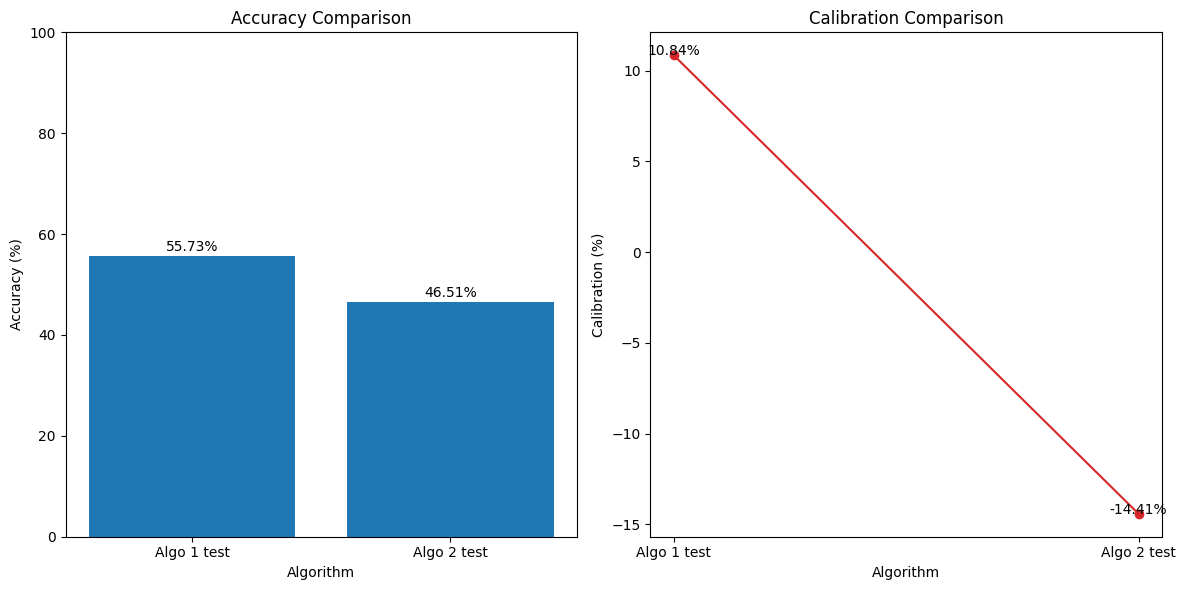

In [ ]:
df = pd.DataFrame(data)

#Plotting two separate graphs for Accuracy and Calibration

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#Plot for Accuracy
ax1.bar(df['Algorithm'], df['Accuracy (%)'], color='tab:blue')
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison')
ax1.set_ylim(0, 100)  # Updating the limit as accuracy is now in percentage
for i, v in enumerate(df['Accuracy (%)']):
    ax1.text(i, v + 1, f"{v:.2f}%", ha='center', color='black')

#Plot for Calibration
ax2.plot(df['Algorithm'], df['Calibration (%)'], color='tab:red', marker='o')
ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Calibration (%)')
ax2.set_title('Calibration Comparison')
for i, v in enumerate(df['Calibration (%)']):
    ax2.text(i, v, f"{v:.2f}%", ha='center', color='black')

#Show the plots
plt.tight_layout()
plt.show()

## 6.2 Training Time Comparison

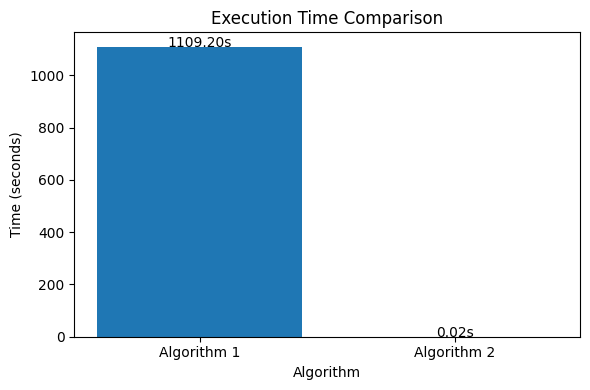

In [ ]:
#Data for execution time
times_data = {
    'Algorithm': ['Algorithm 1', 'Algorithm 2'],
    'Time (seconds)': [1109.20, 0.023218631744384766]
}

#Convert to DataFrame
times_df = pd.DataFrame(times_data)

#Update the time for Algorithm 2
times_df.at[1, 'Time (seconds)'] = 0.023218631744384766

#Re-plot for Execution Time with updated data
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(times_df['Algorithm'], times_df['Time (seconds)'], color=['tab:blue', 'tab:green'])
ax.set_xlabel('Algorithm')
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time Comparison')
for i, v in enumerate(times_df['Time (seconds)']):
    ax.text(i, v + 0.001, f"{v:.2f}s", ha='center', color='black')

plt.tight_layout()
plt.show()